## Under-sampling Method Comparison

In this notebook, we will compare the average precision score, an estimation of the area under the precision recall curve, which tends to be a better metric for imbalanced datasets. And we will also do cross-validation, to obtain a measure of the error of the models.

We will determine if the different under-sampling algorithms discussed in this section improve the performance of Random Forests on different datasets with imbalanced classes.

In [1]:
from collections import Counter

import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import average_precision_score
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.preprocessing import MinMaxScaler

from imblearn.datasets import fetch_datasets

from imblearn.under_sampling import (
    RandomUnderSampler,
    CondensedNearestNeighbour,
    TomekLinks,
    OneSidedSelection,
    EditedNearestNeighbours,
    RepeatedEditedNearestNeighbours,
    AllKNN,
    NeighbourhoodCleaningRule,
    NearMiss,
    InstanceHardnessThreshold
)

In [2]:
undersampler_dict = {

    'random': RandomUnderSampler(
        sampling_strategy='auto',
        random_state=0,
        replacement=False),

    'cnn': CondensedNearestNeighbour(
        sampling_strategy='auto',
        random_state=0,
        n_neighbors=1,
        n_jobs=4),

    'tomek': TomekLinks(
        sampling_strategy='auto',
        n_jobs=4),

    'oss': OneSidedSelection(
        sampling_strategy='auto',
        random_state=0,
        n_neighbors=1,
        n_jobs=4),

    'enn': EditedNearestNeighbours(
        sampling_strategy='auto',
        n_neighbors=3,
        kind_sel='all',
        n_jobs=4),

    'renn': RepeatedEditedNearestNeighbours(
        sampling_strategy='auto',
        n_neighbors=3,
        kind_sel='all',
        n_jobs=4,
        max_iter=100),

    'allknn': AllKNN(
        sampling_strategy='auto',
        n_neighbors=5,
        kind_sel='all',
        n_jobs=4),

    'ncr': NeighbourhoodCleaningRule(
        sampling_strategy='auto',
        n_neighbors=3,
        kind_sel='all',
        n_jobs=4,
        threshold_cleaning=0.5),

    'nm1': NearMiss(
        sampling_strategy='auto',
        version=1,
        n_neighbors=3,
        n_jobs=4),

    'nm2': NearMiss(
        sampling_strategy='auto',
        version=2,
        n_neighbors=3,
        n_jobs=4),

    'iht': InstanceHardnessThreshold(
        estimator=RandomForestClassifier(
            n_estimators=100, random_state=39, max_depth=3, n_jobs=4
        ),
        sampling_strategy='auto',
        random_state=0,
        n_jobs=4,
        cv=3)
}

In [3]:
# these datasets are baked into imbalanced-learn

datasets_ls = [
    'car_eval_34',
    'ecoli',
    'thyroid_sick',
    'arrhythmia',
    'ozone_level'
]

In [4]:
# print class imbalance

for dataset in datasets_ls:
    data = fetch_datasets()[dataset]
    print(dataset)
    print(Counter(data.target))
    print()

car_eval_34
Counter({-1: 1594, 1: 134})

ecoli
Counter({-1: 301, 1: 35})

thyroid_sick
Counter({-1: 3541, 1: 231})

arrhythmia
Counter({-1: 427, 1: 25})

ozone_level
Counter({-1: 2463, 1: 73})



In [5]:
# function to train random forests and evaluate the performance

def run_randomForests(X_train, X_test, y_train, y_test):

    rf = RandomForestClassifier(
        n_estimators=100, random_state=39, max_depth=3, n_jobs=4
    )
    
    cv_results = cross_validate(
        rf, X_train, y_train, scoring="average_precision", cv=3,
    )

    print(
        'Random Forests average precision: {0} +/- {1}'.format(
        cv_results['test_score'].mean(), cv_results['test_score'].std()
        )
    )

    return cv_results['test_score'].mean(), cv_results['test_score'].std()

In [6]:
# to save the results
pr_mean_dict = {}
pr_std_dict = {}
shapes_dict = {}

for dataset in datasets_ls:
    
    pr_mean_dict[dataset] = {}
    pr_std_dict[dataset] = {}
    shapes_dict[dataset] = {}
    
    print(dataset)
    
    # load dataset
    data = fetch_datasets()[dataset]
    
    # separate train and test
    X_train, X_test, y_train, y_test = train_test_split(
        data.data,  
        data.target, 
        test_size=0.3,
        random_state=0,
    )
    
    # as many undersampling techniques use KNN
    # we set variables in the same scale
    scaler = MinMaxScaler().fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
        
    aps_mean, aps_std = run_randomForests(X_train, X_test, y_train, y_test)
    
    # store results
    pr_mean_dict[dataset]['full_data'] = aps_mean
    pr_std_dict[dataset]['full_data'] = aps_std
    shapes_dict[dataset]['full_data'] = len(X_train)
    
    print()
    
    for undersampler in undersampler_dict.keys():
        
        print(undersampler)
        
        # resample
        X_resampled, y_resampled = undersampler_dict[undersampler].fit_resample(X_train, y_train)
        
        # evaluate performance
        aps_mean, aps_std = run_randomForests(X_resampled, X_test, y_resampled, y_test)
        
        #store results
        pr_mean_dict[dataset][undersampler] = aps_mean
        pr_std_dict[dataset][undersampler] = aps_std
        shapes_dict[dataset][undersampler] = len(X_resampled)
        print()
        
    print()

car_eval_34
Random Forests average precision: 0.74810907315696 +/- 0.06400476183857116

random
Random Forests average precision: 0.9919493319580633 +/- 0.007091591965256225

cnn
Random Forests average precision: 0.8610434509212569 +/- 0.07821459925752866

tomek
Random Forests average precision: 0.7682911988424445 +/- 0.04716796424852616

oss
Random Forests average precision: 0.7862328558451278 +/- 0.04609009106316703

enn
Random Forests average precision: 0.8457163731548545 +/- 0.039088350511191146

renn
Random Forests average precision: 0.8845512992412617 +/- 0.055242703854062374

allknn
Random Forests average precision: 0.8625275807336905 +/- 0.033532596019708635

ncr
Random Forests average precision: 0.769146944249365 +/- 0.050777491148021214

nm1
Random Forests average precision: 0.8305104217925708 +/- 0.1970262302354397

nm2
Random Forests average precision: 0.9210021818424264 +/- 0.046085333132297776

iht
Random Forests average precision: 0.8492508026966875 +/- 0.0706626731862411

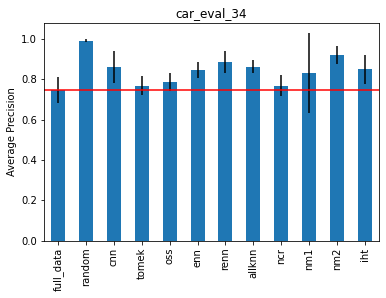

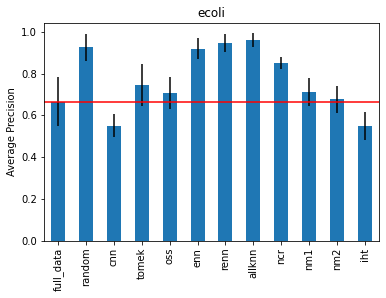

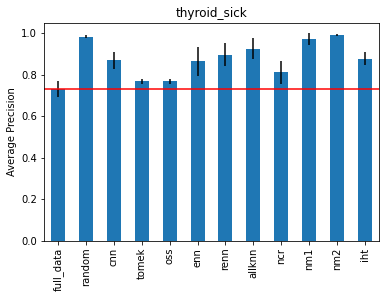

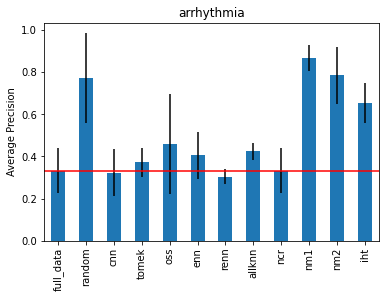

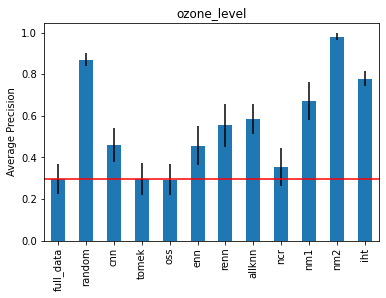

In [7]:
for dataset in datasets_ls:
    
    pr_mean_s = pd.Series(pr_mean_dict[dataset])
    pr_std_s = pd.Series(pr_std_dict[dataset])
    
    pr_mean_s.plot.bar(yerr=[pr_std_s, pr_std_s]
        )
    plt.title(dataset)
    plt.ylabel('Average Precision')
    plt.axhline(pr_mean_dict[dataset]['full_data'], color='r')
    plt.show()

- **Different under-sampling techniques work best for different datasets.**
- ENN, RENN and AllKNN tend to produce similar results, so we may as well just choose one of the 3

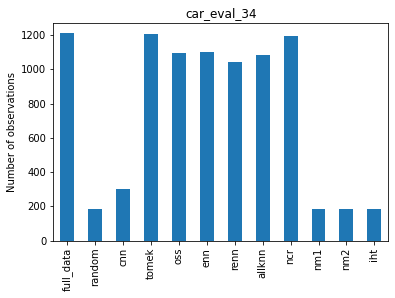

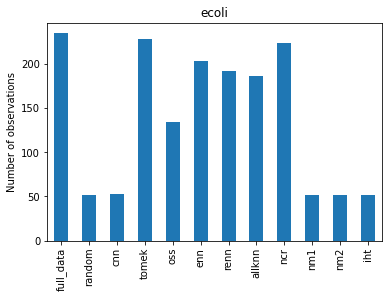

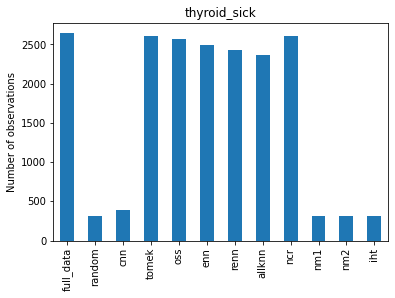

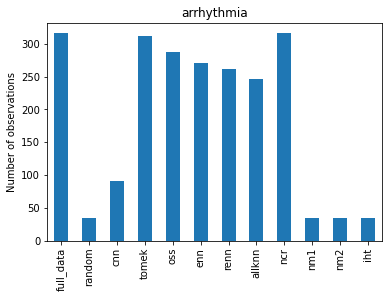

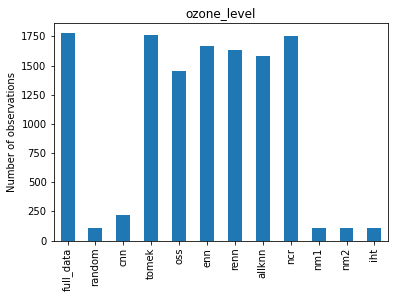

In [8]:
for dataset in datasets_ls:
    
    pd.Series(shapes_dict[dataset]).plot.bar()
    plt.title(dataset)
    plt.ylabel('Number of observations')
    plt.show()